In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import numpy as np
import sys
from pyinstrument import Profiler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from bart_playground import *
import bartz
import arviz as az

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [3]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True)

X = data.data
y = data.target

X = X.values.astype(float)
y = np.array(y).reshape(-1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [4]:
n_chains = 4
chains_mtmh = []
proposal_probs = {"multi_grow": 0.25, "multi_prune": 0.25, "multi_change": 0.4, "multi_swap": 0.1}
for i in range(n_chains):
    bart = MultiBART(ndpost=4000, nskip=1000, n_trees=100, proposal_probs=proposal_probs, multi_tries=10, random_state=i)
    bart.fit(X_train, y_train)
    sigmas = [trace.global_params['eps_sigma2'] for trace in bart.sampler.trace]
    chains_mtmh.append(sigmas)

# chains: shape (n_chains, n_samples)
chains_array = np.array(chains_mtmh)
idata = az.from_dict(posterior={"eps_sigma2": chains_array})
rhat = az.rhat(idata, var_names=["eps_sigma2"])
print("Gelman-Rubin R̂:", rhat)

Iterations: 100%|██████████| 5000/5000 [54:27<00:00,  1.53it/s]


Gelman-Rubin R̂: <xarray.Dataset> Size: 12B
Dimensions:           (eps_sigma2_dim_0: 1)
Coordinates:
  * eps_sigma2_dim_0  (eps_sigma2_dim_0) int32 4B 0
Data variables:
    eps_sigma2        (eps_sigma2_dim_0) float64 8B 1.637


## Default BART

In [5]:
n_chains = 4
chains_default = []
proposal_probs = {"grow": 0.25, "prune": 0.25, "change": 0.4, "swap": 0.1}
for i in range(n_chains):
    bart_default = DefaultBART(ndpost=4000, nskip=1000, n_trees=100, proposal_probs=proposal_probs, random_state=i)
    bart_default.fit(X_train, y_train)
    sigmas = [trace.global_params['eps_sigma2'] for trace in bart_default.sampler.trace]
    chains_default.append(sigmas)

# chains: shape (n_chains, n_samples)
chains_array = np.array(chains_default)
idata = az.from_dict(posterior={"eps_sigma2": chains_array})
rhat = az.rhat(idata, var_names=["eps_sigma2"])
print("Gelman-Rubin R̂:", rhat)

Iterations: 100%|██████████| 5000/5000 [04:14<00:00, 19.67it/s]

Gelman-Rubin R̂: <xarray.Dataset> Size: 12B
Dimensions:           (eps_sigma2_dim_0: 1)
Coordinates:
  * eps_sigma2_dim_0  (eps_sigma2_dim_0) int32 4B 0
Data variables:
    eps_sigma2        (eps_sigma2_dim_0) float64 8B 1.696


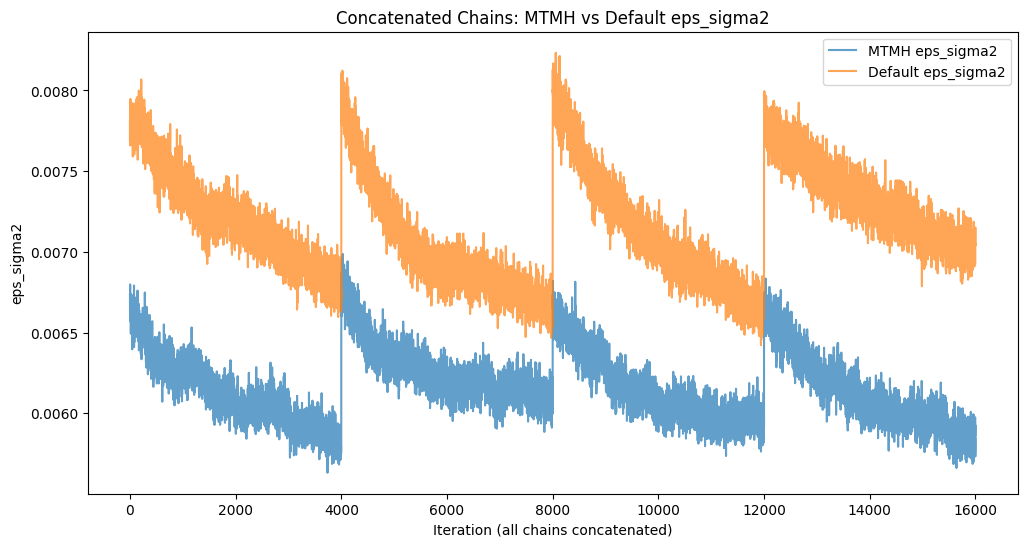

In [6]:
mtmh_long = np.concatenate(chains_mtmh)
default_long = np.concatenate(chains_default)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(mtmh_long, label='MTMH eps_sigma2', alpha=0.7)
plt.plot(default_long, label='Default eps_sigma2', alpha=0.7)
plt.xlabel('Iteration (all chains concatenated)')
plt.ylabel('eps_sigma2')
plt.legend()
plt.title('Concatenated Chains: MTMH vs Default eps_sigma2')
plt.show()